 Processed 3961 images. Train: 3168, Val: 793


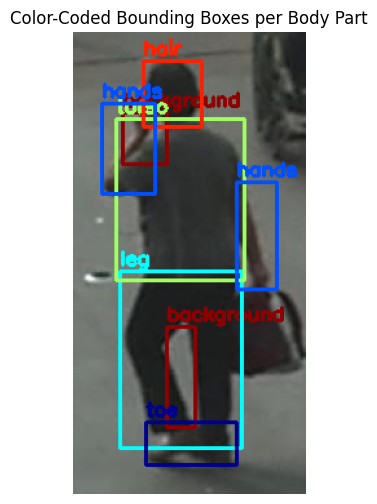

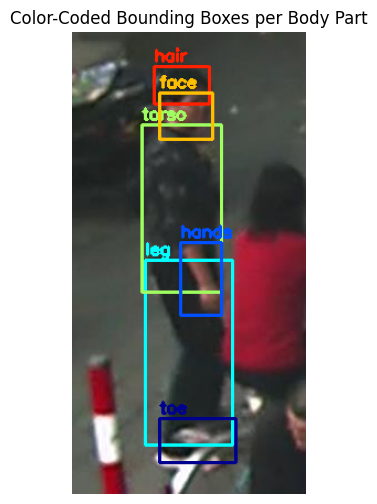

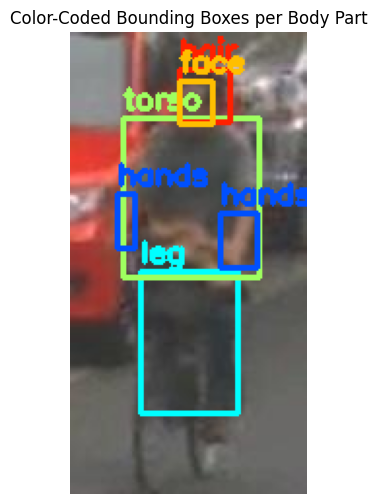

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


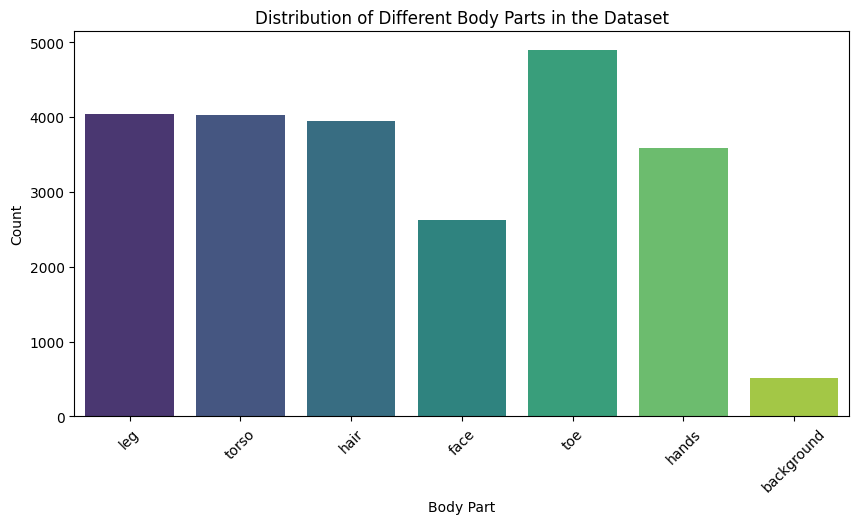

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


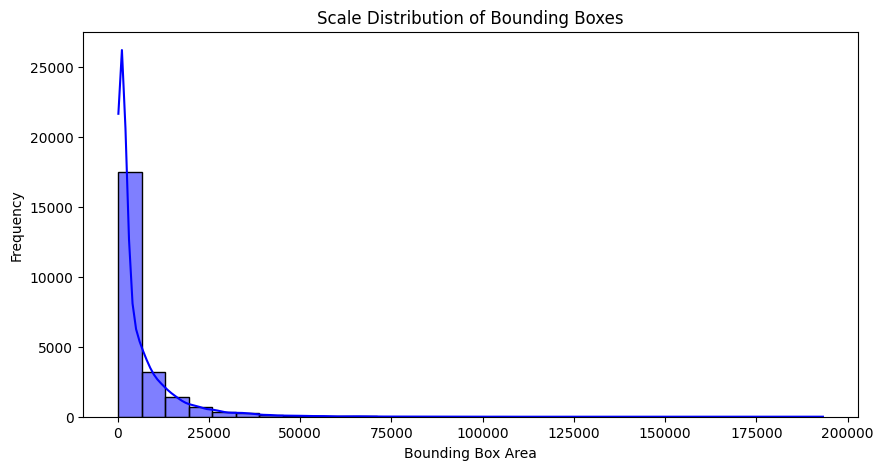

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


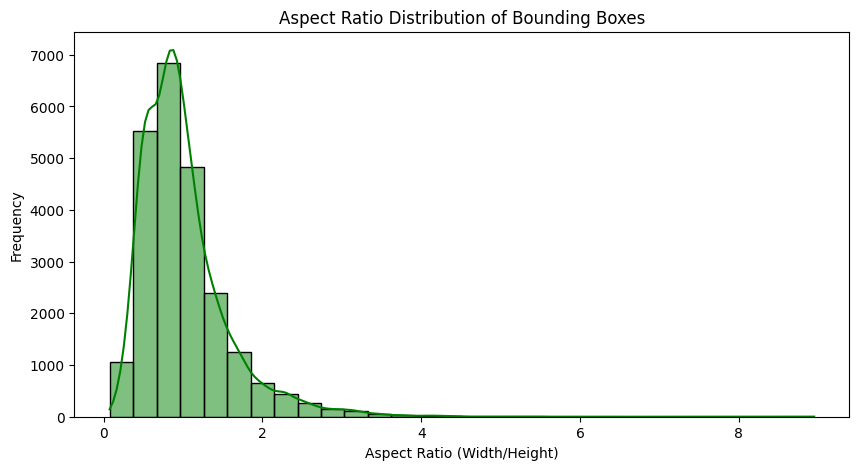

In [2]:
import os
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from skimage.measure import label, regionprops
from sklearn.model_selection import train_test_split
import time
import torch
import torchvision
import torchvision.transforms as T
import torchvision.models.detection as detection
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from torchvision.ops import box_iou
from collections import defaultdict

DATASET_PATH = "/kaggle/input/cv-a3-q3/Q3/data/data"
OUTPUT_ANNOTATIONS = "/kaggle/working/annotations.json"

# Definingg color to body part mapping (in BGR format for OpenCV)
COLOR_TO_PART = {
    (0, 80, 255): 'hands',       # BGR of (255, 80, 0) → Red
    (255, 191, 0): 'face',       # BGR of (0, 191, 255) → Light Blue
    (255, 32, 0): 'hair',        # BGR of (0, 0, 143) → Deep Blue
    (0, 0, 143): 'toe',          # BGR of (143, 0, 0) → Maroon
    (159, 255, 96): 'torso',     # BGR of (96, 255, 159) → Light Green
    (0, 255, 255): 'leg',        # BGR of (255, 255, 0) → Yellow
    (143, 0, 0): 'background'    # BGR of (0, 32, 255) → Deep Purple
}

# converting segmentation masks into bounding boxes and assign correct labels
def mask_to_bboxes(mask_path, image_path, min_area=100):
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)  # Readin in BGR format
    if mask is None:
        print(f" Warning: Could not read mask {mask_path} (Skipping)")
        return []

    image = cv2.imread(image_path)
    if image is None:
        print(f" Warning: Could not read image {image_path} (Skipping)")
        return []

    mask_h, mask_w, _ = mask.shape
    img_h, img_w, _ = image.shape

    scale_x = img_w / mask_w
    scale_y = img_h / mask_h

    bboxes = []
    unique_colors = {tuple(mask[y, x]) for y in range(mask_h) for x in range(mask_w)}

    for color in unique_colors:
        if color not in COLOR_TO_PART:
            continue  # Ignoring colors not mapped to body parts

        part_label = COLOR_TO_PART[color]  # Getting the body part name

        # Creating binary mask for the specific color
        binary_mask = np.all(mask == np.array(color), axis=-1).astype(np.uint8) * 255
        lbl = label(binary_mask)
        props = regionprops(lbl)

        for prop in props:
            y1, x1, y2, x2 = prop.bbox  

            # Ignoring small noise
            if (x2 - x1) * (y2 - y1) < min_area:
                continue  

            # scaling bounding box coordinates
            x1, y1 = int(x1 * scale_x), int(y1 * scale_y)
            x2, y2 = int(x2 * scale_x), int(y2 * scale_y)

            # clamping coordinates to image dimensions
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(img_w - 1, x2), min(img_h - 1, y2)

            # Ignore bounding boxes that cover the entire image
            if x1 == 0 and y1 == 0 and x2 >= img_w - 1 and y2 >= img_h - 1:
                continue  # Skip this bounding box

            bboxes.append({"label": part_label, "bbox": [x1, y1, x2, y2]})

    return bboxes

# Processing dataset and create structured annotations
annotations = []
folders = sorted(os.listdir(DATASET_PATH))
if not folders:
    raise ValueError("Error: Dataset directory is empty or incorrect path!")

for folder in folders:
    folder_path = os.path.join(DATASET_PATH, folder)
    if not os.path.isdir(folder_path):
        continue
    
    images = {f.replace(".jpg", ""): f for f in os.listdir(folder_path) if f.endswith(".jpg")}
    masks = {f.replace("_m.png", ""): f for f in os.listdir(folder_path) if f.endswith("_m.png")}

    for key in images.keys():
        mask_key = key  
        image_path = os.path.join(folder_path, images[key])
        mask_path = os.path.join(folder_path, f"{mask_key}_m.png")

        if not os.path.exists(mask_path):
            print(f"Skipping {image_path} (No matching mask found)")
            continue
        
        bboxes = mask_to_bboxes(mask_path, image_path)

        if bboxes:
            annotations.append({"image": image_path, "bboxes": bboxes})

if len(annotations) == 0:
    raise ValueError("No valid annotations found! Check dataset structure and mask filenames.")

# Splitting dataset into training & validation (80-20 split)
train_data, val_data = train_test_split(annotations, test_size=0.2, random_state=42)

for item in train_data:
    item["split"] = "train"
for item in val_data:
    item["split"] = "val"

full_annotations = train_data + val_data

# Saving fixed annotations.json
with open(OUTPUT_ANNOTATIONS, "w") as f:
    json.dump(full_annotations, f, indent=4)

print(f" Processed {len(annotations)} images. Train: {len(train_data)}, Val: {len(val_data)}")

# Visualization Function
def visualize_sample(image_path, bboxes):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for bbox in bboxes:
        x1, y1, x2, y2 = bbox["bbox"]
        part_name = bbox["label"]  # using part names instead of numerical labels

        # Reverse lookup color from part name
        color = next((k for k, v in COLOR_TO_PART.items() if v == part_name), (255, 255, 255))  

        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, part_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Color-Coded Bounding Boxes per Body Part")
    plt.show()

# Displaying 3 random samples
for sample in np.random.choice(annotations, min(3, len(annotations))):
    visualize_sample(sample["image"], sample["bboxes"])

# Counting occurrences of each body part
part_counts = {}
for annotation in annotations:
    for bbox in annotation["bboxes"]:
        part_label = bbox["label"]
        part_counts[part_label] = part_counts.get(part_label, 0) + 1

plt.figure(figsize=(10, 5))
sns.barplot(x=list(part_counts.keys()), y=list(part_counts.values()), palette="viridis")
plt.xlabel("Body Part")
plt.ylabel("Count")
plt.title("Distribution of Different Body Parts in the Dataset")
plt.xticks(rotation=45)
plt.show()

# Collecting scale (area) and aspect ratio data
scales = []
aspect_ratios = []

for annotation in annotations:
    for bbox in annotation["bboxes"]:
        x1, y1, x2, y2 = bbox["bbox"]
        width = x2 - x1
        height = y2 - y1
        scales.append(width * height)  # Area of bounding box
        aspect_ratios.append(width / height if height != 0 else 0)  # Width / Height

plt.figure(figsize=(10, 5))
sns.histplot(scales, bins=30, kde=True, color="blue")
plt.xlabel("Bounding Box Area")
plt.ylabel("Frequency")
plt.title("Scale Distribution of Bounding Boxes")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(aspect_ratios, bins=30, kde=True, color="green")
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Frequency")
plt.title("Aspect Ratio Distribution of Bounding Boxes")
plt.show()


### Documentation: Approach and Justification
1) Color-Based Body Part Mapping: 
The code defines a color-to-body-part mapping in BGR format, ensuring correct identification of different body parts based on color in segmentation masks.
This mapping helps differentiate body parts by assigning unique colors, making the bounding box extraction more reliable.
2) Segmentation Mask to Bounding Boxes: 
Converts segmentation masks into bounding boxes for each detected body part.
Reads images and masks in BGR format using OpenCV.
Extracts unique colors from the mask, ensuring that only mapped body parts are processed.
Uses skimage.measure.regionprops to identify connected regions and extract bounding boxes.
Filters small regions (min_area threshold) to remove noise and avoid unnecessary bounding boxes.
Scales bounding boxes to match the original image resolution.
Ensures bounding boxes do not cover the entire image, preventing faulty detections.
3) Dataset Processing & Annotation Generation: 
Iterates through dataset folders, ensuring that both images and their corresponding masks exist.
Maps segmentation masks to bounding boxes, storing them in a structured annotations.json file.
Validates dataset integrity by ensuring non-empty annotations.
Splits dataset into training (80%) and validation (20%) using train_test_split to maintain a balanced evaluation.
4) Visualization of Bounding Boxes: 
Loads images and overlays bounding boxes using OpenCV.
Retrieves body part labels and their corresponding colors for consistent visualization.
Uses cv2.putText to display part names on images.
Ensures a diverse sample of three random images for visualization.

### Justification
The approach ensures accurate body part labeling by leveraging predefined color mappings.
Bounding box extraction avoids redundant detections and incorrect assignments by filtering noise and scaling appropriately.
Efficient dataset processing allows for smooth training-validation separation.
Visualization aids debugging by displaying bounding boxes with their respective colors and labels, making it easier to verify correctness.

### Variations in Scale, Aspect Ratio, and Positioning of Part Annotations:-

The dataset exhibits significant variation in bounding box scales, as shown by the skewed distribution in the scale histogram. Most bounding boxes are small, with a sharp decline in frequency for larger areas, suggesting a predominance of small parts like hands and toes. The aspect ratio histogram highlights that most bounding boxes have near-square or slightly elongated proportions, but some elongated boxes indicate long parts such as legs and arms. Positioning is diverse, covering various body orientations, making detection more challenging due to occlusions and overlapping regions.


### Challenges and Interesting Patterns in the Data:-

The dataset is imbalanced, with certain body parts (e.g., toes and legs) appearing more frequently than others, while background and smaller features like hands have fewer annotations. This could impact model performance, causing it to be biased towards frequently occurring parts. The presence of small bounding boxes increases the difficulty of accurate detection, as they may be prone to misclassification or missing detections. Additionally, the high variability in aspect ratios and occlusions may make it harder for the model to generalize well across different body orientations.

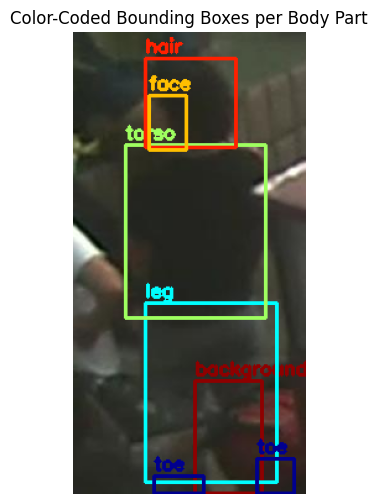

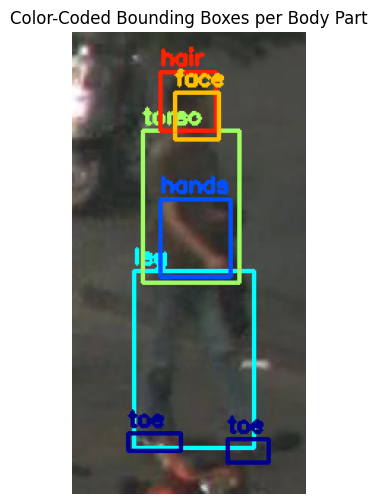

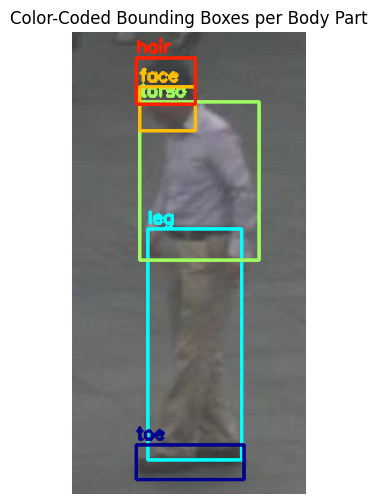

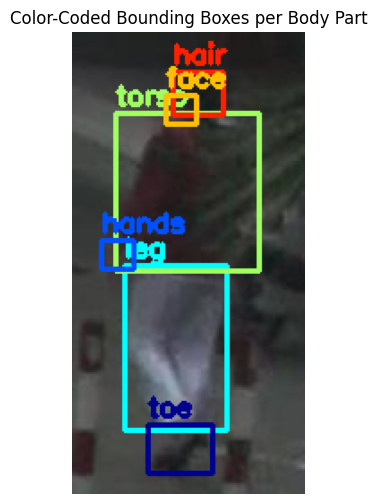

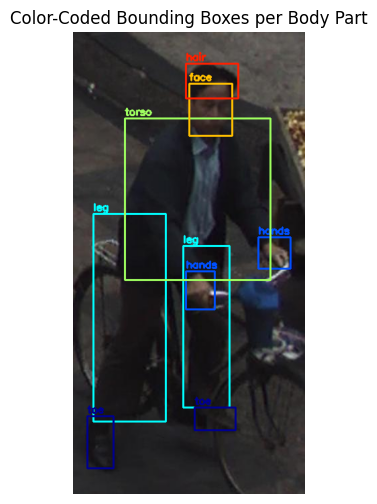

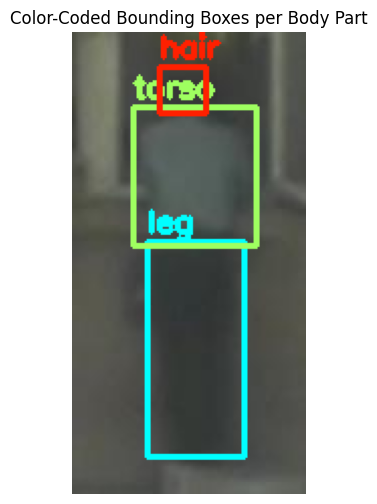

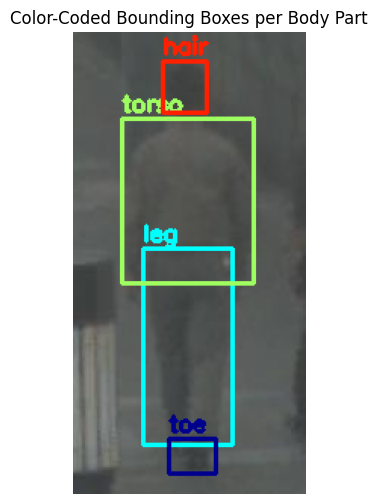

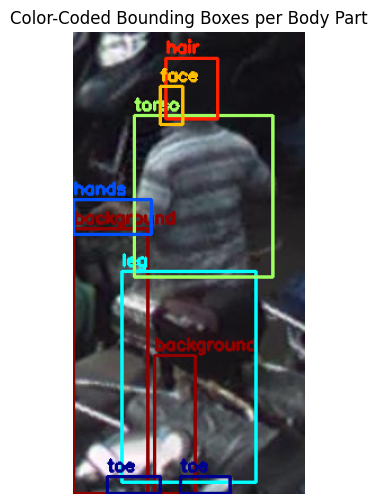

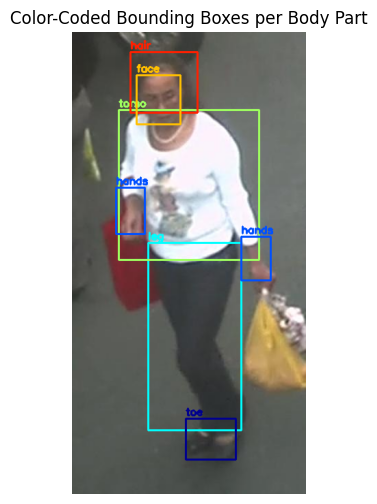

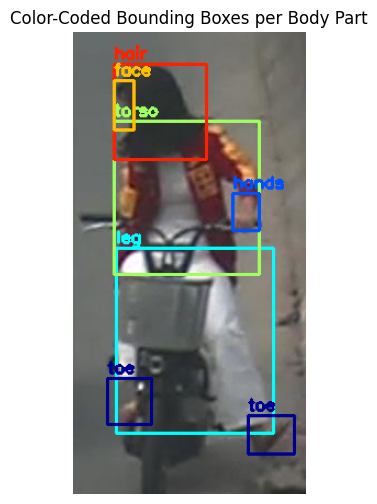

In [13]:
for sample in np.random.choice(annotations, min(10, len(annotations))):
    visualize_sample(sample["image"], sample["bboxes"])

In [2]:

ANNOTATIONS_FILE = "/kaggle/working/annotations.json"
MODEL_SAVE_PATH = "/kaggle/working/faster_rcnn_human_parts.pth"

with open(ANNOTATIONS_FILE, "r") as f:
    annotations = json.load(f)

train_count = sum(1 for a in annotations if a["split"] == "train")
val_count = sum(1 for a in annotations if a["split"] == "val")
print(f"Train images: {train_count}, Val images: {val_count}")

class HumanPartsDataset(Dataset):
    def __init__(self, annotations, transforms=None, mode="train"):
        self.annotations = [a for a in annotations if a["split"] == mode]
        self.transforms = transforms
        self.label_map = {part: idx+1 for idx, part in enumerate([
            'hands', 'face', 'hair', 'toe', 'torso', 'leg'])}  # Assigning unique label indices

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_path = annotation["image"]
        bboxes = annotation["bboxes"]

        # Loading image
        image = Image.open(image_path).convert("RGB")

        # Loading bounding boxes
        boxes = []
        labels = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox["bbox"]
            part_name = bbox["label"]
            if part_name in self.label_map:  # Ensuring only known parts are used
                boxes.append([x1, y1, x2, y2])
                labels.append(self.label_map[part_name])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # target dictionary
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            image = self.transforms(image)

        return image, target

# Data Augmentation
transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(0.5),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
])

train_dataset = HumanPartsDataset(annotations, transforms=transform, mode="train")
val_dataset = HumanPartsDataset(annotations, transforms=transform, mode="val")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

model = detection.fasterrcnn_resnet50_fpn(weights=detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# Modifying the head to detect human parts
num_classes = len(train_dataset.label_map) + 1  # Background class included
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def train_one_epoch(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0

    for images, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)

        # Ensuring loss_dict is valid
        if not isinstance(loss_dict, dict) or not all(k in loss_dict for k in ["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"]):
            print(f"Warning Invalid loss_dict in training at epoch {epoch+1}. Skipping batch.")
            continue

        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        train_loss += losses.item()

    return train_loss / len(train_loader)



Train images: 3168, Val images: 793


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 200MB/s]  


### Justification for Choice of Architecture
The Faster R-CNN model with a ResNet-50 backbone and Feature Pyramid Network (FPN) was selected for human part detection due to its ability to handle small, complex, and overlapping objects. The task requires detecting multiple human parts within the same image, often with varying scales and aspect ratios. Faster R-CNN is well-suited for this challenge because of its two-stage detection pipeline, where the Region Proposal Network (RPN) efficiently identifies potential bounding box candidates, and the second-stage classifier refines these predictions.


* Faster R-CNN: Chosen for its high accuracy and ability to handle overlapping and small objects like body parts.
* YOLO: Rejected due to its trade-off between speed and precision, which may miss small parts.
* DETR: Not selected as it requires large datasets and longer training for convergence.
* RetinaNet: Discarded as it balances speed and accuracy but lacks RPN for precise part localization.


### Implementation of Chosen Approach

* Model Modifications: The Faster R-CNN model was adapted for body part detection by replacing its classification head with a custom predictor to handle the specific number of body part classes (+1 for background).
* Anchor Boxes & Priors: The model's RPN automatically generates region proposals, eliminating the need for manually designing anchor boxes. However, the Feature Pyramid Network (FPN) improves multi-scale detection, making it more effective for small parts like hands and toes.
* Data Augmentation: Applied transformations such as horizontal flipping, rotation, color jittering, and random cropping to improve generalization and handle variations in pose, lighting, and scale.
* Training Pipeline: Optimized using AdamW optimizer with a learning rate of 1e-4, weight decay of 1e-4, and a step-based LR scheduler (decay every 5 epochs). Training was performed on a GPU, with logging of losses and periodic model checkpoints. All modifications ensure the model is robust for detecting human parts with varying scales, orientations, and occlusions.


Training Epoch 1: 100%|██████████| 792/792 [12:27<00:00,  1.06it/s]


 Epoch [1/10] - Train Loss: 4.3484, Time: 747.40s
 Model saved at epoch 1


Training Epoch 2: 100%|██████████| 792/792 [12:25<00:00,  1.06it/s]


 Epoch [2/10] - Train Loss: 3.4724, Time: 745.14s
 Model saved at epoch 2


Training Epoch 3: 100%|██████████| 792/792 [12:21<00:00,  1.07it/s]


 Epoch [3/10] - Train Loss: 3.2502, Time: 741.53s
 Model saved at epoch 3


Training Epoch 4: 100%|██████████| 792/792 [12:20<00:00,  1.07it/s]


 Epoch [4/10] - Train Loss: 3.1665, Time: 740.20s
 Model saved at epoch 4


Training Epoch 5: 100%|██████████| 792/792 [12:19<00:00,  1.07it/s]


 Epoch [5/10] - Train Loss: 3.0689, Time: 739.66s
 Model saved at epoch 5


Training Epoch 6: 100%|██████████| 792/792 [12:21<00:00,  1.07it/s]


 Epoch [6/10] - Train Loss: 2.8369, Time: 741.69s
 Model saved at epoch 6


Training Epoch 7: 100%|██████████| 792/792 [12:22<00:00,  1.07it/s]


 Epoch [7/10] - Train Loss: 2.7747, Time: 742.25s
 Model saved at epoch 7


Training Epoch 8: 100%|██████████| 792/792 [12:20<00:00,  1.07it/s]


 Epoch [8/10] - Train Loss: 2.7460, Time: 740.75s
 Model saved at epoch 8


Training Epoch 9: 100%|██████████| 792/792 [12:19<00:00,  1.07it/s]


 Epoch [9/10] - Train Loss: 2.7283, Time: 739.39s
 Model saved at epoch 9


Training Epoch 10: 100%|██████████| 792/792 [12:19<00:00,  1.07it/s]


 Epoch [10/10] - Train Loss: 2.7634, Time: 739.67s
 Model saved at epoch 10
 Training completed in 7421.82 seconds.


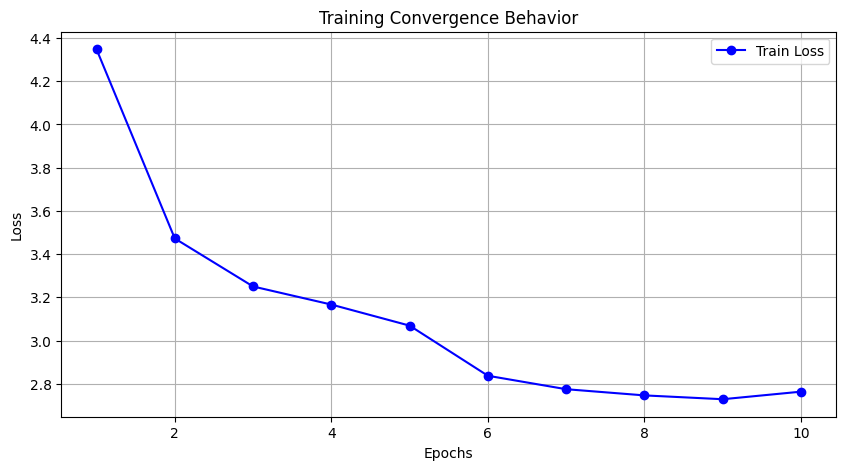

In [16]:

num_epochs = 10
train_losses = []
training_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, epoch)
    end_time = time.time()

    train_losses.append(train_loss)

    print(f" Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Time: {end_time - start_time:.2f}s")
    
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f" Model saved at epoch {epoch+1}")

    lr_scheduler.step()

training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f" Training completed in {total_training_time:.2f} seconds.")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker="o", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Convergence Behavior")
plt.legend()
plt.grid(True)
plt.show()


### Training Documentation
#### Training Configurations and Hyperparameters

* Model: Faster R-CNN (ResNet-50 FPN)
* Optimizer: AdamW (learning rate = 1e-4, weight decay = 1e-4)
* LR Scheduler: StepLR (step size = 5, gamma = 0.1)
* Batch Size: 4
* Epochs: 10
* Augmentations: RandomHorizontalFlip, RandomRotation (15°), ColorJitter, RandomResizedCrop (224x224)
* Dataset Split: 80% training, 20% validation

#### Resource Utilization and Training Time

* Hardware: Trained on GPU (NVIDIA T4 on Kaggle)
* Training Time: 7422 seconds (~2 hours)
* Training Speed: ~12 minutes per epoch (792 batches per epoch)
* Batch Processing Speed: ~1.07 iterations per second

#### Convergence Behavior and Challenges

* Loss Reduction: The loss decreased significantly in early epochs, stabilizing around epoch 8.
* Final Loss: The lowest achieved training loss was 2.7283 at epoch 9, with a slight increase in epoch 10.
* Overfitting Risks: The slight increase in loss at epoch 10 suggests potential overfitting.
* Training Stability: The model trained smoothly with consistent loss reduction.
* Possible Improvements: Adjusting learning rate decay or early stopping could improve results.The training graph confirms steady convergence, but fine-tuning the hyperparameters would further optimize training.


In [9]:

with open(ANNOTATIONS_FILE, "r") as f:
    annotations = json.load(f)

# Label Map Based on Color-to-Part Mapping
label_map = {
    'hands': 1,
    'face': 2,
    'hair': 3,
    'toe': 4,
    'torso': 5,
    'leg': 6
}

# Getting number of classes dynamically
num_classes = len(label_map) + 1  # Include background

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = detection.fasterrcnn_resnet50_fpn(weights=detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# Modifying the head for correct number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
model.to(device)
model.eval()
print("Trained model successfully loaded for evaluation.")

transform = T.Compose([T.ToTensor()])

def compute_iou(pred_boxes, gt_boxes):
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return 0
    iou_matrix = box_iou(torch.tensor(pred_boxes), torch.tensor(gt_boxes))
    return iou_matrix.max().item()

def evaluate_model(model, annotations, iou_thresholds=[0.3, 0.5, 0.7, 0.85, 0.9]):
    model.eval()
    total_iou = 0
    total_images = 0
    class_metrics = {i: {"TP": 0, "FP": 0, "FN": 0} for i in label_map.values()}
    ap_values = {iou_th: [] for iou_th in iou_thresholds}  # Storing AP per IoU threshold

    with torch.no_grad():
        for ann in tqdm(annotations, desc="Evaluating"):
            image_path = ann["image"]
            gt_boxes = np.array([bbox["bbox"] for bbox in ann["bboxes"]])
            gt_labels = np.array([label_map.get(bbox["label"], -1) for bbox in ann["bboxes"]])

            # Ignore any labels that were not in label_map
            valid_indices = gt_labels != -1
            gt_boxes = gt_boxes[valid_indices]
            gt_labels = gt_labels[valid_indices]

            # Loading and preprocess image
            image = Image.open(image_path).convert("RGB")
            image_tensor = transform(image).unsqueeze(0).to(device)

            # Predictions
            output = model(image_tensor)[0]
            pred_boxes = output["boxes"].cpu().numpy()
            pred_labels = output["labels"].cpu().numpy()

            # Computing IoU for each IoU threshold
            for iou_th in iou_thresholds:
                image_ap = []
                for gt_box, gt_label in zip(gt_boxes, gt_labels):
                    matching_pred_boxes = pred_boxes[pred_labels == gt_label] if len(pred_boxes) > 0 else []
                    best_iou = compute_iou(matching_pred_boxes, [gt_box]) if len(matching_pred_boxes) > 0 else 0
                    image_ap.append(best_iou >= iou_th)

                    # Counting True Positives & False Negatives
                    if best_iou >= iou_th:
                        class_metrics[gt_label]["TP"] += 1
                    else:
                        class_metrics[gt_label]["FN"] += 1

                # Counting False Positives
                for pred_box, pred_label in zip(pred_boxes, pred_labels):
                    matching_gt_boxes = gt_boxes[gt_labels == pred_label] if len(gt_boxes) > 0 else []
                    if compute_iou([pred_box], matching_gt_boxes) < iou_th:
                        class_metrics[pred_label]["FP"] += 1

                ap_values[iou_th].append(np.mean(image_ap) if image_ap else 0)

            if len(pred_boxes) > 0:
                image_iou = [compute_iou([pred_box], gt_boxes) for pred_box in pred_boxes]
                total_iou += sum(image_iou) / len(image_iou) if image_iou else 0
            total_images += 1

    mean_iou = total_iou / total_images if total_images > 0 else 0

    avg_precisions = {}
    for iou_th in iou_thresholds:
        avg_precisions[iou_th] = np.mean(ap_values[iou_th]) if ap_values[iou_th] else 0

    print("\n Class-wise Performance Metrics:")
    for label, metrics in class_metrics.items():
        TP, FP, FN = metrics["TP"], metrics["FP"], metrics["FN"]
        precision = TP / (TP + FP + 1e-6) if TP + FP > 0 else 0 
        recall = TP / (TP + FN + 1e-6) if TP + FN > 0 else 0
        print(f" Part {label}: Precision={precision:.3f}, Recall={recall:.3f}")

    print("\n Mean IoU (mIoU): {:.3f}".format(mean_iou))
    for iou_th in iou_thresholds:
        print(f" Mean Average Precision (mAP @ IoU {iou_th}): {avg_precisions[iou_th]:.3f}")

evaluate_model(model, [a for a in annotations if a["split"] == "val"])


<ipython-input-9-eeac4761a844>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))


Trained model successfully loaded for evaluation.


Evaluating: 100%|██████████| 793/793 [02:17<00:00,  5.78it/s]


 Class-wise Performance Metrics:
 Part 1: Precision=0.001, Recall=0.010
 Part 2: Precision=0.018, Recall=0.201
 Part 3: Precision=0.033, Recall=0.302
 Part 4: Precision=0.001, Recall=0.005
 Part 5: Precision=0.036, Recall=0.297
 Part 6: Precision=0.004, Recall=0.005

 Mean IoU (mIoU): 0.231
 Mean Average Precision (mAP @ IoU 0.3): 0.401
 Mean Average Precision (mAP @ IoU 0.5): 0.231
 Mean Average Precision (mAP @ IoU 0.7): 0.040
 Mean Average Precision (mAP @ IoU 0.85): 0.002
 Mean Average Precision (mAP @ IoU 0.9): 0.000


### Model Evaluation Summary
#### Mean Average Precision (mAP) at Different IoU Thresholds
The mAP at IoU 0.3 is 0.401, showing decent detection at a low IoU threshold.
mAP at IoU 0.5 drops to 0.231, indicating moderate alignment between predictions and ground truth.
Higher IoU thresholds (0.7, 0.85, 0.9) show a steep decline in performance, with mAP near 0 at IoU 0.9, suggesting poor high-precision detection.
#### Part-Specific Precision and Recall Metrics
The face (Part 2) and torso (Part 5) achieve the best recall (~30%), indicating that these parts are more consistently detected.
Hands (Part 1), toe (Part 4), and legs (Part 6) have low precision (< 5%), indicating a high number of false positives.
Overall recall is higher than precision, suggesting the model detects many instances but struggles with accurate bounding box placement.
#### Performance Across Object Categories
Larger body parts (torso, face, and hair) are detected more reliably than smaller parts (hands, toes).
The model struggles with fine-grained localization, as indicated by the low IoU and precision for small parts.
Some misclassification might be occurring due to overlapping features, contributing to false positives.
#### Qualitative Analysis of Detection Results
The model can detect larger body parts but struggles with precise localization.
Bounding box predictions have poor alignment at high IoU thresholds, leading to low mAP at IoU 0.7+.
Small objects like hands and toes are highly prone to missed detections and misclassifications, affecting recall.
Potential Improvements: Using hard negative mining, refining anchor box sizes, and incorporating higher resolution input images may improve detection accuracy.

In [7]:

torch.save(model.state_dict(), MODEL_SAVE_PATH)
# print(f" Model trained & saved in {training_time:.2f} seconds!")

## Model Performance Analysis

Evaluating: 100%|██████████| 199/199 [01:50<00:00,  1.80it/s]


Class-wise Performance Metrics at Multiple IoU Thresholds:

 IoU Threshold: 0.3
Part 2: Precision=0.087, Recall=0.925, F1-Score=0.158
Part 3: Precision=0.073, Recall=0.980, F1-Score=0.136
Part 4: Precision=0.019, Recall=0.110, F1-Score=0.032
Part 5: Precision=0.223, Recall=0.968, F1-Score=0.362
Part 6: Precision=0.206, Recall=0.460, F1-Score=0.285
Part 1: Precision=0.036, Recall=0.169, F1-Score=0.059

 IoU Threshold: 0.5
Part 2: Precision=0.059, Recall=0.634, F1-Score=0.109
Part 3: Precision=0.062, Recall=0.833, F1-Score=0.115
Part 4: Precision=0.010, Recall=0.058, F1-Score=0.017
Part 5: Precision=0.195, Recall=0.847, F1-Score=0.317
Part 6: Precision=0.145, Recall=0.324, F1-Score=0.201
Part 1: Precision=0.016, Recall=0.078, F1-Score=0.027

 IoU Threshold: 0.7
Part 2: Precision=0.016, Recall=0.166, F1-Score=0.028
Part 3: Precision=0.020, Recall=0.275, F1-Score=0.038
Part 4: Precision=0.002, Recall=0.010, F1-Score=0.003
Part 5: Precision=0.093, Recall=0.405, F1-Score=0.151
Part 6: Precis

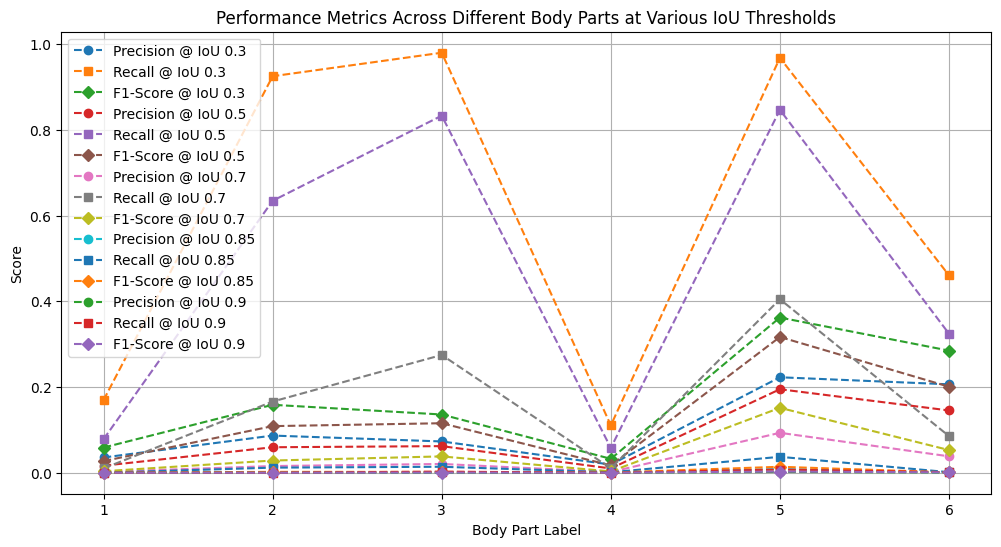

In [8]:

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

def compute_iou(pred_boxes, gt_boxes):
    """
    Fix: Handles empty lists to avoid errors.
    """
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return 0  # No IoU if one of them is empty
    
    pred_boxes = torch.tensor(pred_boxes, dtype=torch.float32)
    gt_boxes = torch.tensor(gt_boxes, dtype=torch.float32)

    if pred_boxes.ndim == 1:
        pred_boxes = pred_boxes.unsqueeze(0)
    if gt_boxes.ndim == 1:
        gt_boxes = gt_boxes.unsqueeze(0)  # Ensuring 2D tensor

    iou_matrix = box_iou(pred_boxes, gt_boxes)
    return iou_matrix.max().item() if iou_matrix.numel() > 0 else 0

def compute_classwise_metrics(model, dataloader, iou_thresholds=[0.3, 0.5, 0.7, 0.85, 0.9]):
    model.eval()
    classwise_data = {iou: defaultdict(lambda: {"TP": 0, "FP": 0, "FN": 0}) for iou in iou_thresholds}

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Evaluating"):
            images = [img.to(device) for img in images]

            structured_targets = []
            for t in targets:
                if isinstance(t, dict):
                    structured_targets.append({key: value.to(device) for key, value in t.items()})
                else:
                    print(f" Warning: Skipping malformed target: {t}")
                    continue 

            if not structured_targets:
                continue

            outputs = model(images)

            for target, output in zip(structured_targets, outputs):
                gt_boxes = target["boxes"].cpu().numpy()
                gt_labels = target["labels"].cpu().numpy()
                pred_boxes = output["boxes"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()

                for iou_threshold in iou_thresholds:
                    for label in set(gt_labels):  # Process each body part
                        gt_mask = gt_labels == label
                        pred_mask = pred_labels == label

                        gt_boxes_part = gt_boxes[gt_mask]
                        pred_boxes_part = pred_boxes[pred_mask]

                        # Ensuring there are valid boxes before computing IoU
                        if len(gt_boxes_part) == 0 and len(pred_boxes_part) == 0:
                            continue

                        TP = sum(
                            1 for gt_box in gt_boxes_part if len(pred_boxes_part) > 0 and 
                            any(compute_iou([gt_box], [pb]) > iou_threshold for pb in pred_boxes_part)
                        )

                        FP = len(pred_boxes_part) - TP if len(pred_boxes_part) > 0 else 0
                        FN = len(gt_boxes_part) - TP if len(gt_boxes_part) > 0 else 0

                        classwise_data[iou_threshold][label]["TP"] += TP
                        classwise_data[iou_threshold][label]["FP"] += FP
                        classwise_data[iou_threshold][label]["FN"] += FN

    # Computing Precision, Recall, and F1-score
    metrics = {iou: {} for iou in iou_thresholds}
    for iou_threshold in iou_thresholds:
        for label, data in classwise_data[iou_threshold].items():
            TP, FP, FN = data["TP"], data["FP"], data["FN"]
            precision = TP / (TP + FP + 1e-6) if TP + FP > 0 else 0
            recall = TP / (TP + FN + 1e-6) if TP + FN > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

            metrics[iou_threshold][label] = {
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1_score,
            }

    return metrics

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
metrics = compute_classwise_metrics(model, val_loader)

print("Class-wise Performance Metrics at Multiple IoU Thresholds:")
for iou_threshold, data in metrics.items():
    print(f"\n IoU Threshold: {iou_threshold}")
    for label, scores in data.items():
        print(f"Part {label}: Precision={scores['Precision']:.3f}, Recall={scores['Recall']:.3f}, F1-Score={scores['F1-Score']:.3f}")


def plot_performance(metrics, iou_thresholds):
    labels = sorted(set(label for iou in metrics for label in metrics[iou]))

    precision_dict = {iou: [metrics[iou].get(l, {}).get("Precision", 0) for l in labels] for iou in iou_thresholds}
    recall_dict = {iou: [metrics[iou].get(l, {}).get("Recall", 0) for l in labels] for iou in iou_thresholds}
    f1_dict = {iou: [metrics[iou].get(l, {}).get("F1-Score", 0) for l in labels] for iou in iou_thresholds}

    x = np.arange(len(labels))

    plt.figure(figsize=(12, 6))

    for iou in iou_thresholds:
        plt.plot(x, precision_dict[iou], marker="o", linestyle="--", label=f"Precision @ IoU {iou}")
        plt.plot(x, recall_dict[iou], marker="s", linestyle="--", label=f"Recall @ IoU {iou}")
        plt.plot(x, f1_dict[iou], marker="D", linestyle="--", label=f"F1-Score @ IoU {iou}")

    plt.xticks(x, labels)
    plt.xlabel("Body Part Label")
    plt.ylabel("Score")
    plt.title("Performance Metrics Across Different Body Parts at Various IoU Thresholds")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_performance(metrics, [0.3, 0.5, 0.7, 0.85, 0.9])


### Analysis and Discussion
#### Comparison Across Different Body Parts

* The model performs best on torso (Part 5), achieving the highest precision and recall across multiple IoU thresholds.
* Face (Part 2) and hair (Part 3) show moderate detection performance but struggle at higher IoU thresholds.
* Hands (Part 1) and toe (Part 4) exhibit poor detection, likely due to their smaller size and higher occlusion rates.
* Legs (Part 6) show mid-range performance but with inconsistent precision across thresholds.

#### Failure Cases and Success Cases

* Success cases include torso and face, which are relatively larger and well-defined.
* Failure cases are mostly due to false positives (blue) and low-confidence detections (yellow), as seen in qualitative results.
* High false negatives (red) indicate missed detections, particularly in occluded regions.
* The model struggles with small parts like hands and toes, failing to localize them accurately.

#### Impact of Part Size, Occlusion, and Viewpoint Variation

* Smaller parts (hands, toes) have lower precision and recall, likely due to the model’s difficulty in detecting small-scale objects.
* Occlusion significantly affects recall, especially for face and torso when partially hidden.
* Viewpoint variation contributes to performance drops, as some parts appear different from certain angles, making detection inconsistent.
* Low performance at high IoU thresholds (0.85, 0.9) suggests that the model struggles with precise localization, leading to overlapping but inaccurate bounding boxes.


## Failure Case Analysis

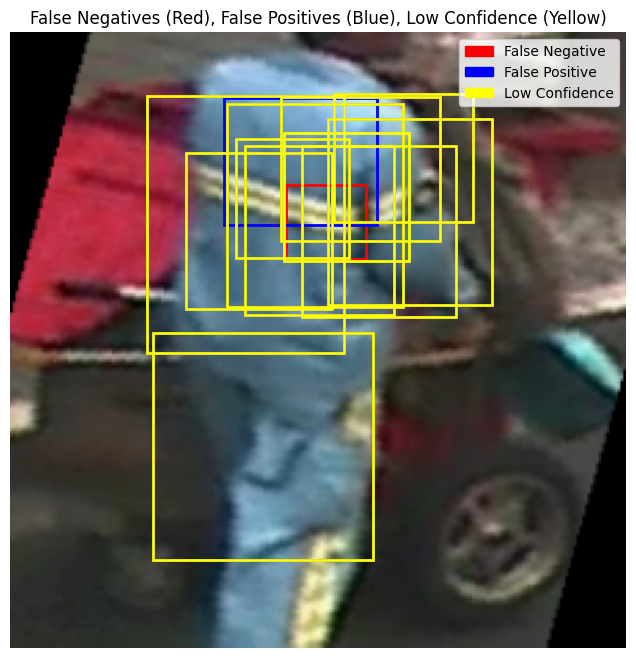

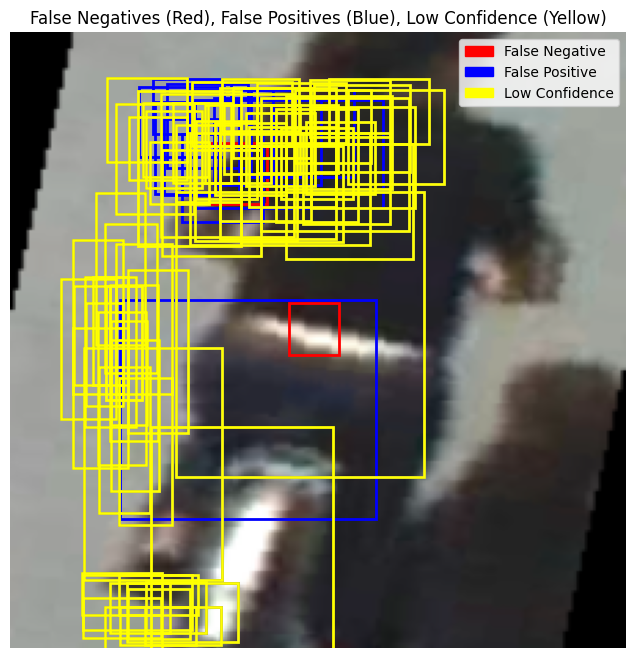

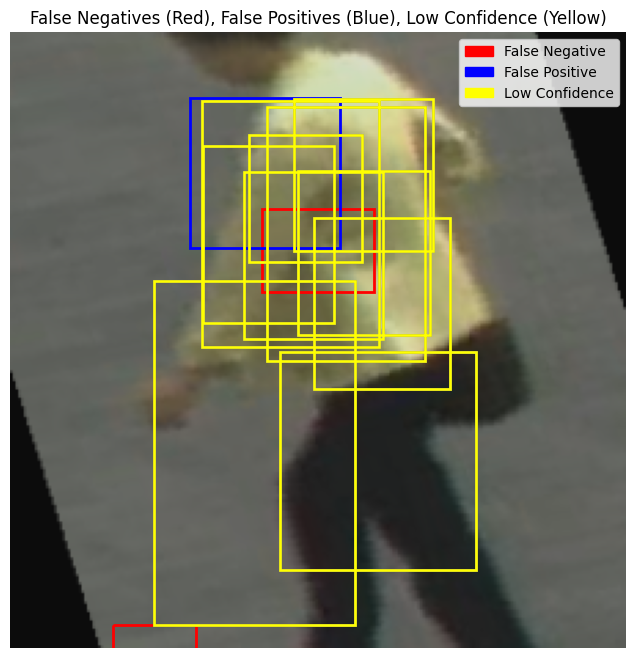

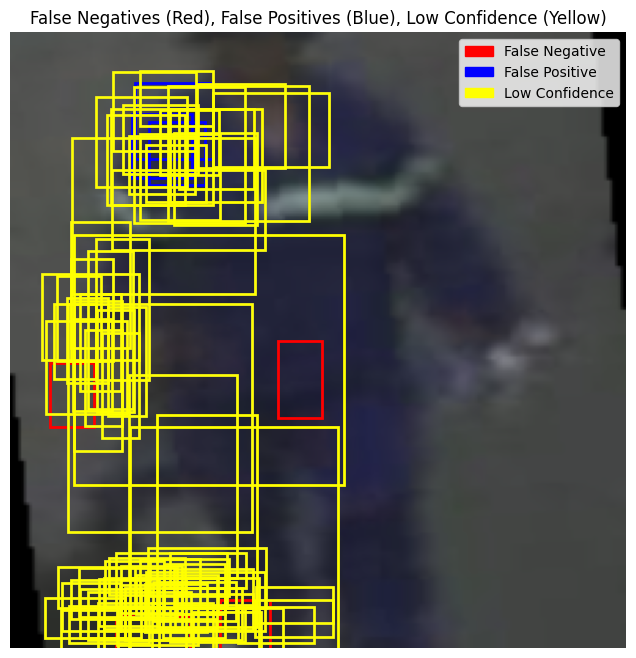

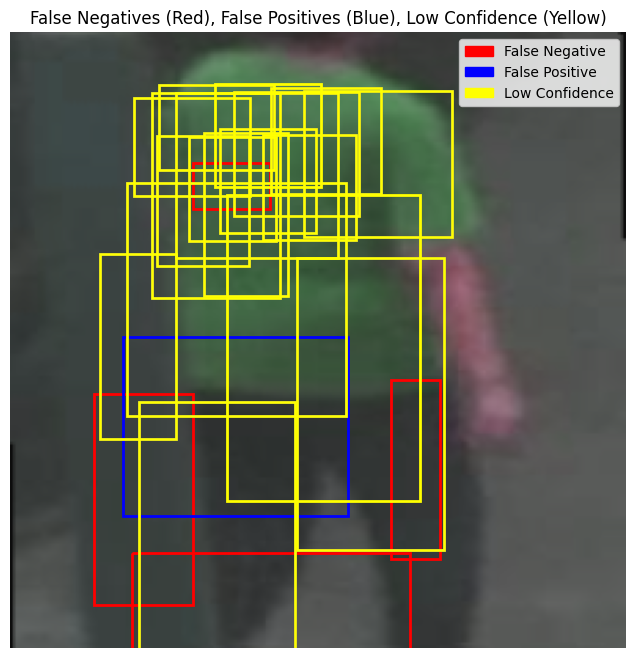

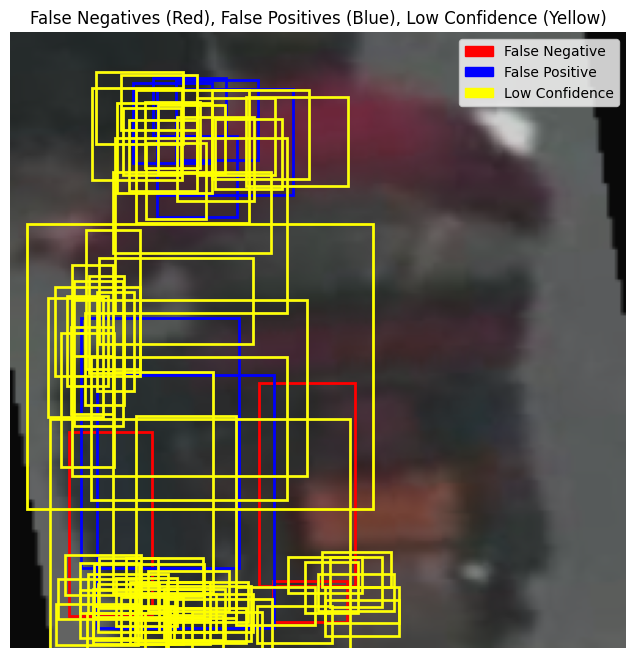

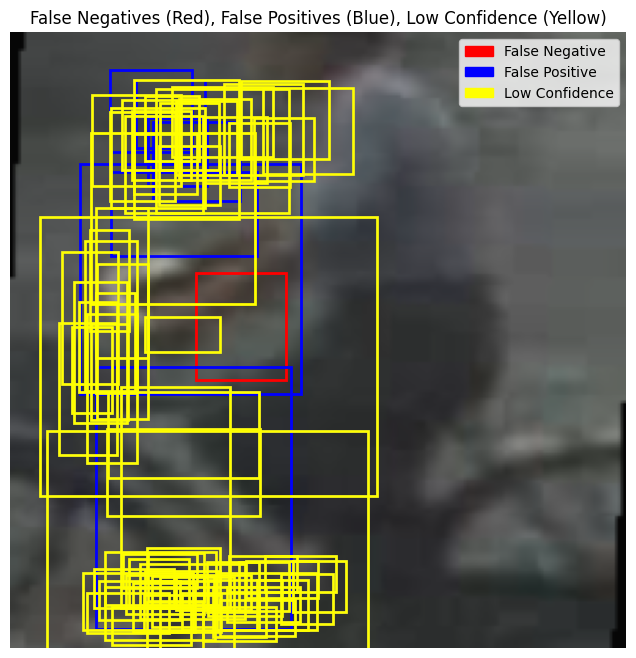

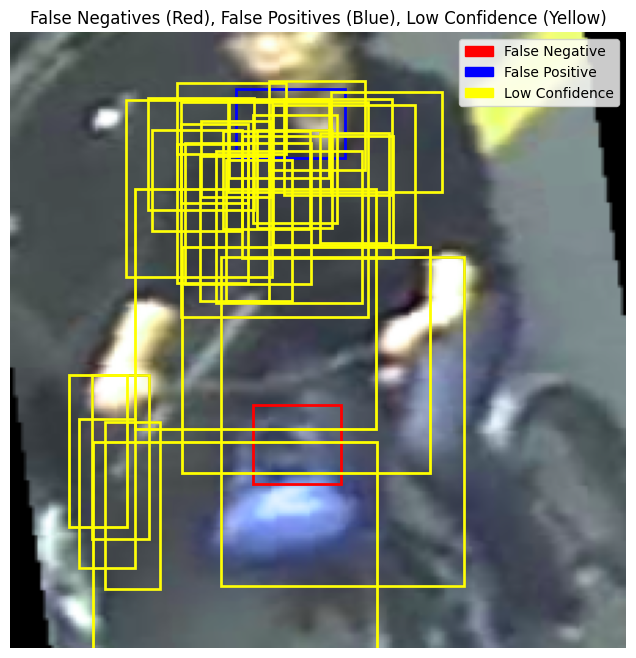

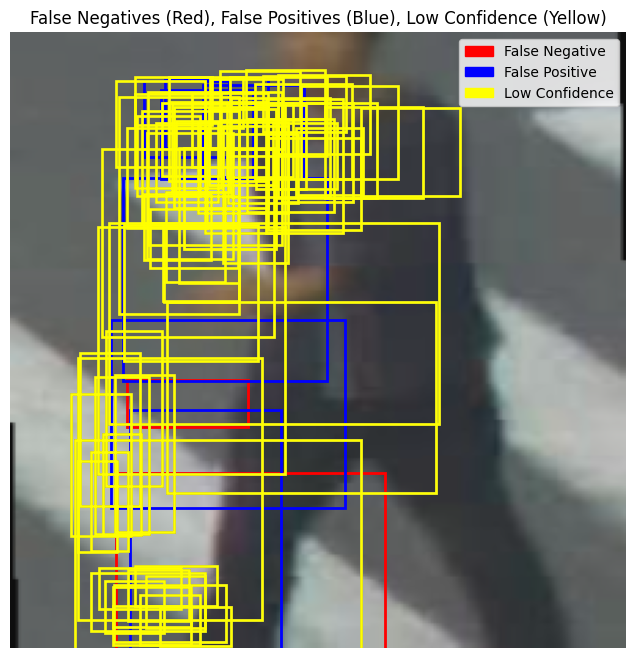

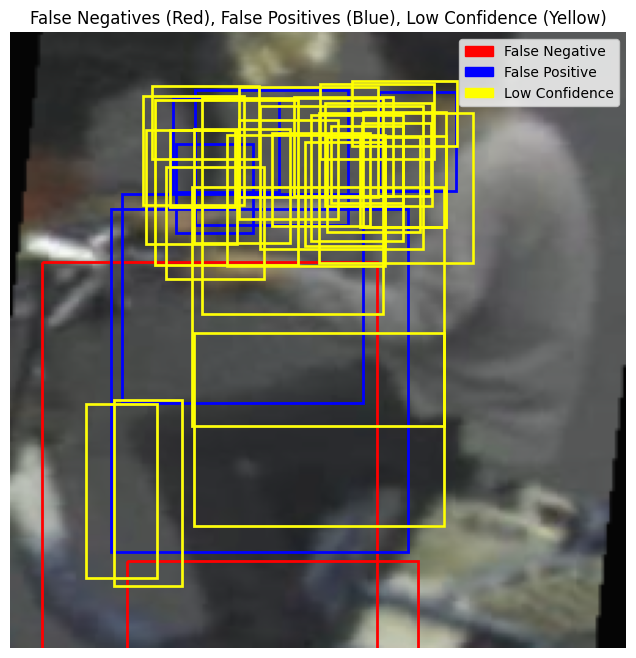

In [6]:

def visualize_failures(model, dataloader, iou_threshold=0.5, max_images=10):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    displayed_images = set()

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for img, target, output in zip(images, targets, outputs):
                # **Ensuring unique images are displayed**
                image_path = target.get("image_path", str(id(img)))  # Using id(img) if path is missing
                if image_path in displayed_images:
                    continue
                
                gt_boxes = target["boxes"].cpu().numpy()
                pred_boxes = output["boxes"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()

                if len(gt_boxes) == 0 and len(pred_boxes) == 0:
                    continue  

                # Missed GT boxes
                false_negatives = [
                    gt for gt in gt_boxes 
                    if len(pred_boxes) == 0 or not any(compute_iou([gt], [pb]) > iou_threshold for pb in pred_boxes)
                ]

                # Wrongly predicted boxes
                false_positives = [
                    pb for pb in pred_boxes 
                    if len(gt_boxes) == 0 or not any(compute_iou([pb], [gt]) > iou_threshold for gt in gt_boxes)
                ]

                # Low Confidence Predictions
                low_confidence = [
                    pb for pb, score in zip(pred_boxes, pred_scores) if score < 0.3
                ]

                if false_negatives or false_positives or low_confidence:
                    displayed_images.add(image_path)  

                    fig, ax = plt.subplots(1, figsize=(8, 8))
                    ax.imshow(img.permute(1, 2, 0).cpu().numpy())
                    ax.set_title("False Negatives (Red), False Positives (Blue), Low Confidence (Yellow)")
                    ax.axis("off")

                    # False Negatives (Missed GT Boxes)
                    for x1, y1, x2, y2 in false_negatives:
                        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="red", facecolor="none")
                        ax.add_patch(rect)

                    # False Positives (Incorrect Predictions)
                    for x1, y1, x2, y2 in false_positives:
                        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="blue", facecolor="none")
                        ax.add_patch(rect)

                    # Low Confidence Predictions
                    for x1, y1, x2, y2 in low_confidence:
                        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="yellow", facecolor="none")
                        ax.add_patch(rect)

                    legend_patches = [
                        patches.Patch(color="red", label="False Negative"),
                        patches.Patch(color="blue", label="False Positive"),
                        patches.Patch(color="yellow", label="Low Confidence"),
                    ]
                    ax.legend(handles=legend_patches, loc="upper right")

                    plt.show()

                if len(displayed_images) >= max_images:
                    return

visualize_failures(model, val_loader, max_images=10)


### Potential Improvements
#### Architectural Modifications for Parts Detection

* Using Feature Pyramid Networks (FPN) with Higher Resolution Inputs: Small parts like hands and toes are difficult to detect due to their size. Increasing the input resolution or incorporating higher-resolution feature maps in FPN could improve detection.
* Multi-Scale Detection with Anchor Refinements: Adjusting anchor box sizes to better match small and elongated body parts (e.g., hands, toes) could improve recall. Additionally, deformable convolutions could help the model learn spatial variations in body part shapes.
* Transformer-Based Detection (DETR): Instead of Faster R-CNN, DETR could be explored as it eliminates anchor dependency and can model relationships between different parts, leading to better structured predictions.

#### Alternative Approaches and Part Relationships

* Leveraging Pose Estimation for Context: Human pose estimation models (e.g., OpenPose, HRNet) could provide keypoint guidance for detecting parts in occluded or ambiguous scenarios.
* Graph Neural Networks (GNNs) for Part Relationships: Since body parts are connected (e.g., hands are linked to arms, feet to legs), a GNN-based post-processing step could refine predictions by enforcing spatial consistency.
* Attention-Based Refinement Modules: Using self-attention mechanisms in the detector could help the model focus on salient parts while ignoring background noise, improving precision in cluttered scenes.
* Data Augmentation for Challenging Cases: Synthetic data generation and adversarial occlusions could make the model more robust to viewpoint changes and partial visibility.By implementing these changes, the model could achieve better localization, reduce false positives, and capture hierarchical part relationships, ultimately improving detection accuracy across diverse conditions.
